In [1]:
import sys, os
import numpy as np
import scipy.signal as ssignal
import matplotlib.pyplot as plt
import ipywidgets as widgets

sys.path.append(os.path.abspath('./comm'))
import skcomm as skc

%config InlineBackend.figure_format = 'svg'

plt.style.use('noelle.mplstyle')

#inline, widget 
%matplotlib inline

import schemdraw
from schemdraw import dsp

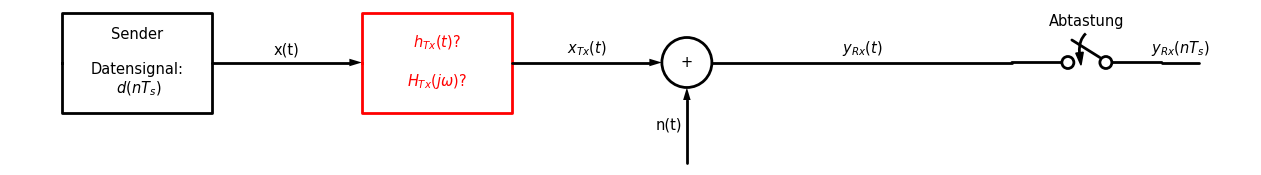

In [2]:
with schemdraw.Drawing(show=True) as d:
        d.config(fontsize=12)
        d += dsp.Box(label='Sender\n\nDatensignal:\n $d(nT_s)$')
        d += dsp.Arrow().label('x(t)')       
        d += dsp.Box(label='$h_{Tx}(t)$?\n\n$H_{Tx}(j\omega)$?').color('r')
        d += dsp.Arrow().label('$x_{Tx}(t)$')
        d += (c1 := dsp.Circle(label='+'))
        d += dsp.Arrow().label('n(t)').at(c1.S).down().reverse().length(d.unit/2)
        d += schemdraw.elements.lines.Line().label('$y_{Rx}(t)$').at(c1.E).right().length(d.unit*2)
        d += schemdraw.elements.Switch(action='close').label('Abtastung').reverse()
        d += schemdraw.elements.lines.Line().label('$y_{Rx}(nT_s)$').length(d.unit/4)

# schemfig = d.draw()
# schemfig.fig.patch.set_facecolor('b')
# schemfig.fig.patch.set_alpha(0.)
# display(schemfig)
        

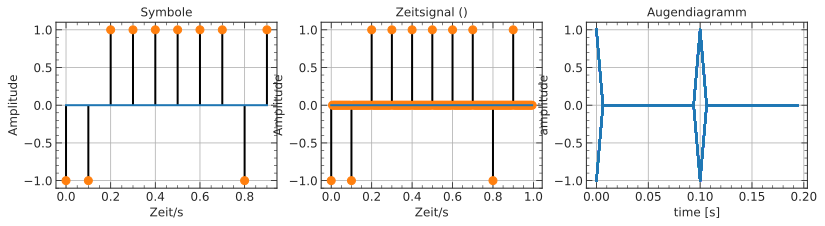

<Figure size 450x300 with 0 Axes>

In [3]:
# generate signal
n_symb = 3000
upsam = 16
symb_rate = 10
levels = 2

t = skc.utils.create_time_axis(sample_rate=symb_rate*upsam,n_samples=n_symb*upsam)
f = np.fft.fftshift(np.fft.fftfreq(n=n_symb*upsam,d=1/(symb_rate*upsam)))
# init signal
sig = skc.signal.Signal()
sig.symbol_rate = symb_rate
# generate modulation symbols
sig.symbols = np.random.randint(low=0,high=levels,size=n_symb)
sig.symbols = (sig.symbols[0]-(levels-1)/2)*2
# upsampling (inserting zeros between symbols )
sig.samples = np.zeros(sig.symbols[0].size*upsam)
sig.samples[0][::upsam] = sig.symbols[0]
sig.sample_rate = symb_rate*upsam

# plotting
n_row = 1
n_col = 3
fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
fig, axs = plt.subplots(figsize=fig_size, nrows=n_row, ncols=n_col,squeeze=False)

axs[0][0].stem(t[:10*upsam:upsam],sig.symbols[0][:10],basefmt='C0',linefmt='k',markerfmt='C1')
axs[0][0].set(title='Symbole',ylabel='Amplitude',xlabel='Zeit/s')

axs[0][1].stem(t[:10*upsam],sig.samples[0][:10*upsam],basefmt='C0',linefmt='k',markerfmt='C1')
axs[0][1].set(title='Zeitsignal ()',ylabel='Amplitude',xlabel='Zeit/s')

sig.plot_eye(boundaries=[10*upsam,-10*upsam],fNum=fig,tit='Augendiagramm')
plt.tight_layout()
plt.show()


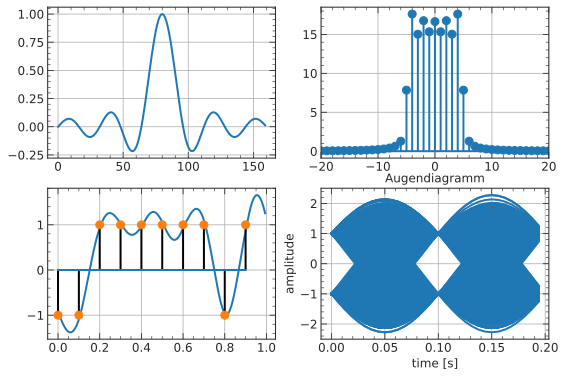

In [4]:
# pulsforming
# rect impluse response
# h = np.ones(upsam)
# h = np.ones(upsam*2-1)

# sinc impluse response
tmp = np.linspace(-10/2,10/2, 10*upsam,endpoint=False)
h = np.sinc(tmp)

# # windowed sinc
# tmp = np.linspace(-10/2,10/2, 10*upsam,endpoint=False)
# h = np.sinc(tmp)
# h = h * ssignal.windows.gaussian(upsam*10,std=10)

# % % odd symmetry with respect to fN
# % H = zeros(1,length(x)/2);
# % triangle...
# % H(1:nSymb) = 1-((0:nSymb-1)./nSymb); % generate (onesided) transfer funtion
# % % ..or other 
# % H(1:nSymb/4) = 1;
# % H(nSymb/4+1:3*nSymb/4) = 1-((0:nSymb/2-1)./nSymb*2); % generate (onesided) transfer funtion
# % H (3*nSymb/4+1:nSymb) = 0;
# % 
# % H = H .* upsam; % set correct amplitude
# % H = ifftshift([fliplr(H), H]); % generate (twoseded) transfer function
# % h = real(ifftshift(ifft(H))); % back into time domain

# filter signal
sig_filt = sig.copy()
sig_filt.samples[0] = ssignal.fftconvolve(sig.samples[0], h, 'same')

# plotting
n_row = 2
n_col = 2
fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
fig, axs = plt.subplots(figsize=fig_size, nrows=n_row, ncols=n_col,squeeze=False)

axs[0][0].plot(h)

axs[0][1].stem(np.fft.fftshift(np.fft.fftfreq(n=h.size,d=1/(symb_rate*upsam))),np.abs(np.fft.fftshift(np.fft.fft(h))),basefmt='C0')
axs[0][1].set_xlim([-2*symb_rate,2*symb_rate])

axs[1][0].plot(t[:10*upsam],sig_filt.samples[0][:10*upsam])
axs[1][0].stem(t[:10*upsam:upsam],sig_filt.symbols[0][:10],basefmt='C0',linefmt='k',markerfmt='C1')

sig_filt.plot_eye(boundaries=[10*upsam+1,-10*upsam+1],fNum=fig,tit='Augendiagramm')
plt.show()


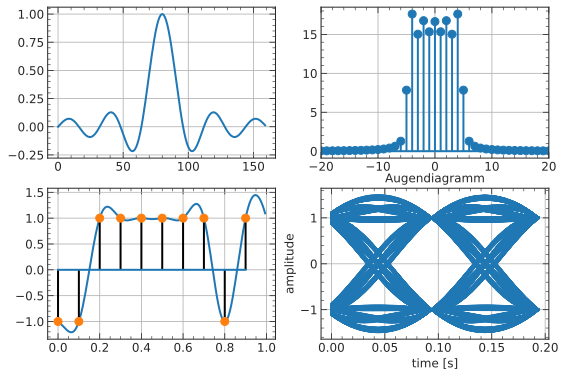

In [5]:
# raised cosine
ro = 0.5

# filter signal
sig_filt = sig.copy()
sig_filt.pulseshaper(upsampling=upsam,pulseshape='rc',roll_off=ro)

# plotting
n_row = 2
n_col = 2
fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
fig, axs = plt.subplots(figsize=fig_size, nrows=n_row, ncols=n_col,squeeze=False)

axs[0][0].plot(h)

axs[0][1].stem(np.fft.fftshift(np.fft.fftfreq(n=h.size,d=1/(symb_rate*upsam))),np.abs(np.fft.fftshift(np.fft.fft(h))),basefmt='C0')
axs[0][1].set_xlim([-2*symb_rate,2*symb_rate])

axs[1][0].plot(t[:10*upsam],sig_filt.samples[0][:10*upsam])
axs[1][0].stem(t[:10*upsam:upsam],sig_filt.symbols[0][:10],basefmt='C0',linefmt='k',markerfmt='C1')

sig_filt.plot_eye(boundaries=[10*upsam+1,-10*upsam+1],fNum=fig,tit='Augendiagramm')
plt.show()